In [2]:
import numpy as np 
import matplotlib.pyplot as plt

import torch

import programs.NN as NN
import programs.visualize as vis

from programs.Poisson_Convection import *

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Gap width
w = 1.

# Proppant viscosity
mu0 = 0.1

# Maximum proppant concentration
cmax = 1.

# Influent proppant concentration
cin = 0.5

# Incoming flow rate
v_in = 0.1

# Mixture flow
Q0 = v_in*w

# Length of permeable area
chi = 0.4

# Width
H = 1.

# Length
L = 1.

# Number of randomly generated points for IC and BC
cond_points = 32

# Bounds for x,y,t
x_min, x_max, y_min, y_max, t_min, t_max = 0., L, 0., H, 0., 2
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Number of collocation points
collocation = 32

# Condition arrays
# First arr is cond, second is type (0 for Dirichlet and 1 for Neumann), third is psi-func
cond = -12 * mu0 * v_in / w**2 * (1 - cin/cmax)**(-2.5)
c_condition = [[0, 0, cin, 0], [1, 1, 0, 1], [False, False, True, True]]
p_condition = [[0, 0, cond, cond], [1, 1, 1, 1], [False, False, True, True]]
print (cond, collocation**3, (1 - cin/cmax)**(-2.5))

-0.6788225099390858 32768 5.656854249492381


In [5]:
net = Poisson_Convection(w=w, mu0=mu0, cmax=cmax, v_in=v_in, c_in=cin, chi=chi, c_cond=c_condition, p_cond=p_condition,
                         size=boundaries, collocation=collocation, cond_points=cond_points)

C:\Users\ilya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# net.full_save("tty","ttyd")
net.full_load("tty","ttyd.npy")
# net.full_load("data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05","data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05_data.npy")

In [6]:
# weights = [4,4,5,1,4]
# net.weights = weights/np.max(weights)
# print (net.weights)
# net.Adam_epochs = 5000
# net.train()
# net.CL_epochs = [5000, 5000, 5000, 5000, 5000, 5000, 5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000, 5000]
# parameters = {'w':[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]}
# parameters = {'w':[0.087, 0.077, 0.069, 0.055, 0.057, 0.052, 0.047, 0.043, 0.04, 0.037, 0.034, 0.0318, 0.025, 0.02, 0.015, 0.01]}
# parameters = {'w':[0.02, 0.015, 0.01]}
# parameters = {'w': }
# net.CL_train(constants=parameters)

0.042054615914821625 9696


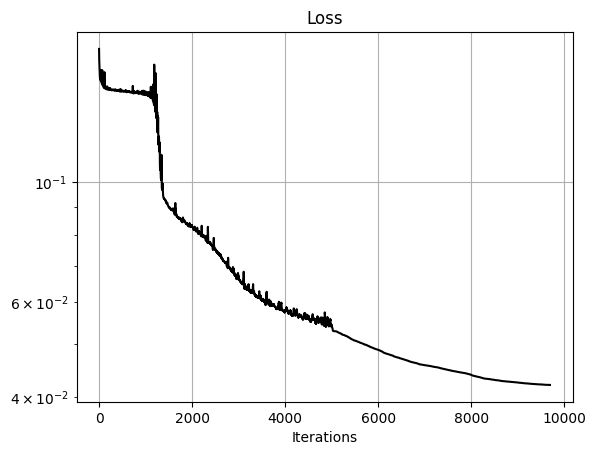

In [7]:
print (net.losses[-1], len(net.losses))
vis.plot_loss(net.losses)

In [8]:
try:
  del u,c,p,u_x,u_y
except NameError:
  None

In [9]:
net.eval_()

Nx = 250
Ny = 250
Nt = 60

t = torch.linspace(t_min, t_max, Nt).to(device)
x = torch.linspace(x_min, x_max, Nx).to(device)
y = torch.linspace(y_min, y_max, Ny).to(device)

mesh_XYT = torch.stack(torch.meshgrid(x,y,t)).reshape(3, -1).T

X = torch.autograd.Variable(mesh_XYT[:,0], requires_grad=True)
Y = torch.autograd.Variable(mesh_XYT[:,1], requires_grad=True)
T = torch.autograd.Variable(mesh_XYT[:,2], requires_grad=True)

n = net.model([X,Y,T])

mu = net.mu0*(1 - n[:,0]/net.cmax)**(-2.5)
u_x = -(net.w**2/(12*mu) * NN.Net.derivative(n[:,1],X))
u_y = -(net.w**2/(12*mu) * NN.Net.derivative(n[:,1],Y))

c = n[:,0].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
p = n[:,1].reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
mu = mu.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
u_x = u_x.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)
u_y = u_y.reshape(Nx, Ny, Nt).data.cpu().numpy().transpose(2,1,0)

t = np.linspace(t_min, t_max, Nt)
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)

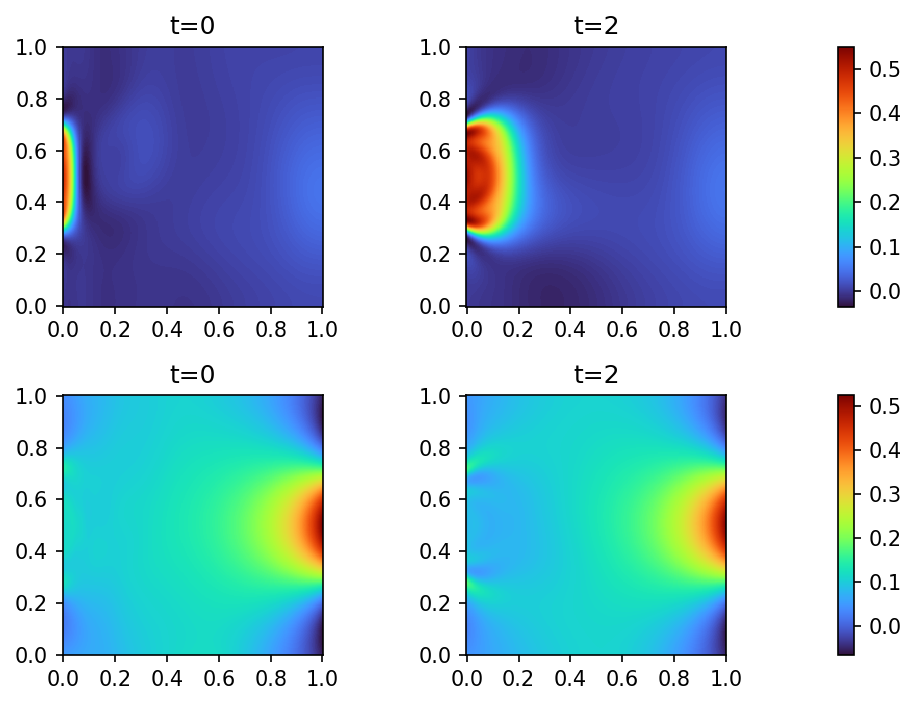

In [10]:
vis.plot_results([c[0],c[-1],u_x[0],u_x[-1]],[x_min, x_max, y_min, y_max], t_max, Nx, Ny)

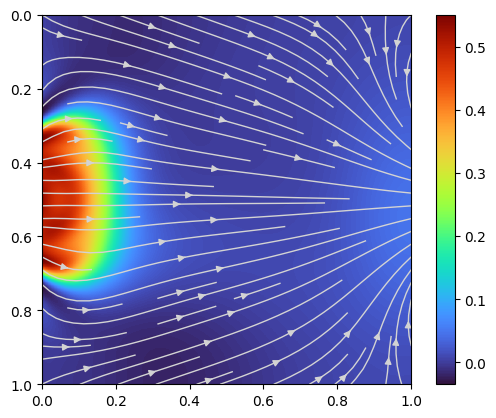

In [11]:
mesh_x, mesh_y = np.meshgrid(x,y)
speed = np.sqrt(u_x[-1]**2 + u_y[-1]**2)
lw = 2*speed/speed.max()
vis.plot(c[-1], limits=[0,1,0,1])
strm = plt.streamplot(mesh_x, mesh_y, u_x[-1], u_y[-1], linewidth=1, color='lightgrey')

-0.6788225099390858
-0.6788225173950195


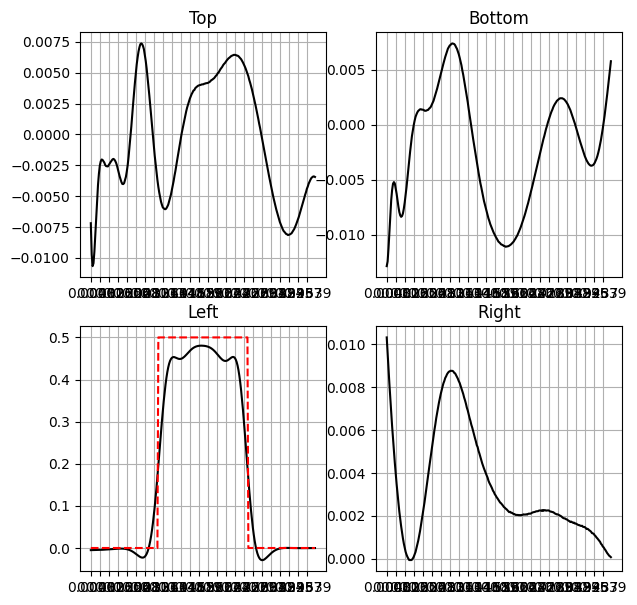

In [12]:
print (np.max(cond))
print (net.p_cond[0][2].min().item())

vis.plot_BC(c[0], x, y, L/(Nx-1), H/(Ny-1), [1,1,0,1])
plt.subplot(223)
plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, net.c_cond[0][2].max().item(), 0), c='red', ls='--')

# vis.plot_BC(p[0], x, y, L/(Nx-1), H/(Ny-1), [1,1,1,1])
# plt.subplot(223)
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, -net.p_cond[0][3].min().item(), 0), c='red', ls='--')

# vis.plot_BC(u_x[0], x, y, L/(Nx-1), H/(Ny-1), [1,1,0,0])
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, net.v_in, 0), c='red', ls='--')

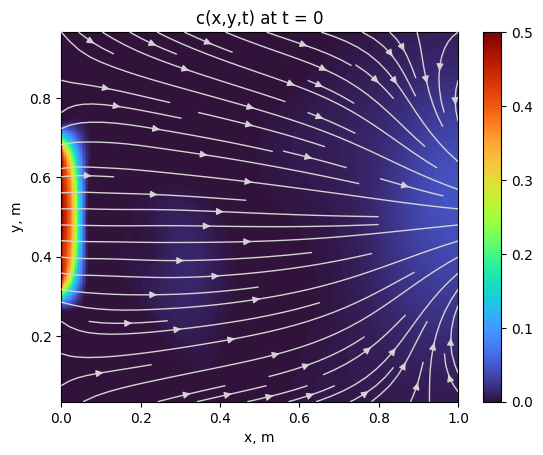

In [13]:
vis.anim_result(c,
                t_max/Nt,
                clims=[0,0.5],
                streamplot_data=[mesh_x,mesh_y,u_x,u_y],
                name='with_arrows',
                title='c(x,y,t)',
                colour='turbo',
                path='gifs',
                savetogif=True,
                showMe=True,
                )